# Econometria Aplicada

## Aula 1 - REGRESSÃO LINEAR: SIMPLES E MÚLTIPLA



João Ricardo Costa Filho \\
[joaocostafilho.com](https://)

## A regressão linear

**Motivação**: \\

Será que os salários dos CEOs estão associados ao retorno sobre o patrimônio (ROE)?

Vamos utilizar os dados do livro do Wooldrige e a aplicação em R do livro do Heiss. \\

* Heiss, F. (2020). Using R for introductory econometrics (pp. 216-217). Düsseldorf, Germany, 2nd edition.

### Pacotes

In [ ]:
install.packages("wooldridge")           # pacote para obter os dados do livro Introductory Econometrics: A Modern Approach, 7e by Jeffrey M. Wooldridge

In [2]:
library(wooldridge)

### Dados

Para obter uma base de dados que já vem em um pacote do R, podemos utilizar o seguinte comando:

In [3]:
data(ceosal1) # base de dados

Quando tivermos dúvidas sobre uma função, podemos utilizar "?":

In [4]:
?sum

E se tivermos dúvidas sobre no que consiste 'ceosal1', como podemos fazer?

Para selecionarmos as primeiras 20 linhas de um 'dataframe', podemos utilizar o seguinte comando:

In [ ]:
head(ceosal1, 20)

E a estrutura dos dados do 'dataframe' pode ser obtida da seguinte forma:

In [ ]:
str( ceosal1 ) # estrutura dos dados

## Visualização dos dados

Pacote para gráficos no R:

In [7]:
library(ggplot2)

Podemos fazer um histograma da variável 'salary' no 'dataframe' ceosal1 rapidamente assim:

In [ ]:
hist( ceosal1$salary )

Ou, de forma um pouco mais elaborada, assim:

In [ ]:
ggplot(ceosal1) +
  geom_histogram(aes(x = salary, y = ..density..), color = "black", fill = "darkred", alpha = 0.8) +
    labs(title = "Histograma do salário dos CEOs", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

Analogamente, faça o histograma da variável 'roe':

Finalmente, façamos a dispersão entre as variáveis 'roe' e 'salary':

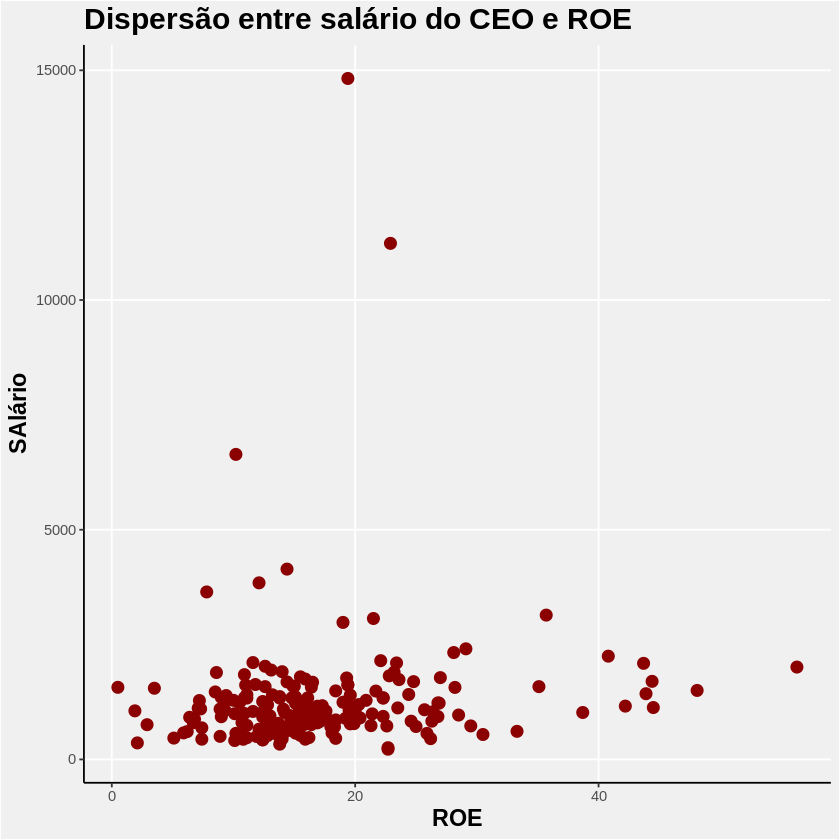

In [ ]:
ggplot(ceosal1, aes( x = roe, y = salary ) ) +
  geom_point( color = 'darkred', size = 3 ) +
  labs(title = "Dispersão entre salário do CEO e ROE",
       x = "ROE",
       y = "Salário") +
         theme_classic() +
  theme(plot.title = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 14, face = "bold"),
        axis.title.y = element_text(size = 14, face = "bold")
        ) +
  theme(panel.background = element_rect(fill = "#f0f0f0"),
        plot.background = element_rect(fill = "#f0f0f0"),
        panel.grid.major = element_line(colour = "white") )

Estatísticas descritivas

Às vezes, pode ser conveniente "anexar" uma dataframe, assim não precisamos acessar as variáveis dele por meio do '$':

In [10]:
attach( ceosal1 )

In [ ]:
# Apenas para fins pedagógicos, vamos criar uma tabela com estatísticas descritivas da seguinte forma:

tabela = matrix( data = NA, ncol = 2, nrow = 4 )

colnames( tabela ) = c( "Salário", "ROE" )
rownames( tabela ) = c( "Média", "Variância", "Desvio-padrão", "Coeficiente de Variação" )

# média
tabela[1,1] = round( mean( salary ), 2 )
tabela[1,2] = round( mean( roe ), 2 )

# variância
tabela[2,1] = round( var( salary ), 2 )
tabela[2,2] = round( var( roe ), 2 )

# desvio-padrão
tabela[3,1] = round( sd( salary ), 2 )
tabela[3,2] = round( sd( roe ), 2 )

# coeficiente de variação
tabela[4,1] = round( sd( salary ) / mean( salary ), 2 )
tabela[4,2] = round( sd( roe ) / mean( roe ), 2 )

print( tabela )

Calcule a covariância entre salários e ROE com a função 'cov':

In [ ]:
# Covariância (amostral)

print('Covariância entre salários e ROE')

round( cov( salary, roe ), 2 )

Calcule a correlação entre salários e ROE com a função 'cor':

### Regressão

Queremos estimar a seguinte regressão: \\
\
$salario_i = \beta_0 + \beta_1 ROE_i + ɛ_i$


In [ ]:
reg = lm( salary ~ roe, data = ceosal1)

summary( reg )

In [ ]:
ggplot(ceosal1, aes( x = roe, y = salary ) ) +
  geom_point( color = 'darkred', size = 3 ) +
  labs(title = "Dispersão entre salário do CEO e ROE",
       x = "ROE",
       y = "Salário") +
         theme_classic() +
  theme(plot.title = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 14, face = "bold"),
        axis.title.y = element_text(size = 14, face = "bold")
        ) +
  theme(panel.background = element_rect(fill = "#f0f0f0"),
        plot.background = element_rect(fill = "#f0f0f0"),
        panel.grid.major = element_line(colour = "white") ) +
    stat_smooth(method = lm, se = FALSE) +
     geom_smooth(method = lm, se = FALSE, fullrange = TRUE) +
  geom_segment(aes(x = roe, y = salary,
                   xend = roe, yend = predict(lm(salary ~ roe, data = ceosal1))),
               alpha = 0.5, linetype = "dotted")


Ou seja, a relação que estimamos é tal que:

$\hat{salario} = 963.19 + 18.50 \text{ }ROE$.

Sendo assim, qual é o valor do salário **esperado** de um CEO cuja empresa tem um ROE de 20? E um ROE de 15? E de 10?

E se quiséssemos fazer a regressão de maneira "manual"?

In [ ]:
b1 = cov( salary, roe) / var( roe )

b0 = mean( salary ) - b1 * mean( roe )

In [ ]:
s1 = b0 + b1 * 20
print( "Salário esperado de um CEO cujo ROE é 20")
round( s1, 2 )
print("")
print("")

s2 = b0 + b1 * 15
print( "Salário esperado de um CEO cujo ROE é 15")
round( s2, 2 )
print("")
print("")

s3 = b0 + b1 * 10
print( "Salário esperado de um CEO cujo ROE é 10")
round( s3, 2 )

## Inferência

Como verificar se a associação entre as variáveis é estatísticamente significativa? Realizados testes de hipótese!

Para $\hat{ \beta}_0$:

$\mathcal{H}_0: \beta_0 = 0$ \\
$\mathcal{H}_a: \beta_0 \neq 0$ \\

Para $\hat{ \beta}_1$:

$\mathcal{H}_0: \beta_1 = 0$ \\
$\mathcal{H}_a: \beta_1 \neq 0$ \\

Vamos simular os dados:

In [ ]:
# Para replicarmos as variáveis pseudo aleatórias
set.seed(1301)

# Definindo os parâmetros

amostras <- 500 # número de amostras

n <- 200        # tamanho de cada amostra

b0 <- 2

b1 <- 3

# Criando as amostras

X <- replicate( amostras, rnorm( n, mean = 10, sd = 2 ) )

print( "Variável X: linhas e colunas")

nrow( X ) # numero de linhas
ncol( X ) # número de colunas

e <- replicate( amostras, rnorm( n, mean = 0, sd = 1 ) )

Y <- b0 + b1 * X + e

print( "Variável Y: linhas e colunas")

nrow( Y ) # numero de linhas
ncol( Y ) # número de colunas

[1] "Variável X: linhas e colunas"


[1] 200

[1] 500

[1] "Variável Y: linhas e colunas"


[1] 200

[1] 500

In [ ]:
# Fazendo as regressões

regressoes <- lapply( 1:amostras,
                      function(i) lm( Y[ , i ] ~ X[ , i ] ) )

betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

beta1 = mean( betas )

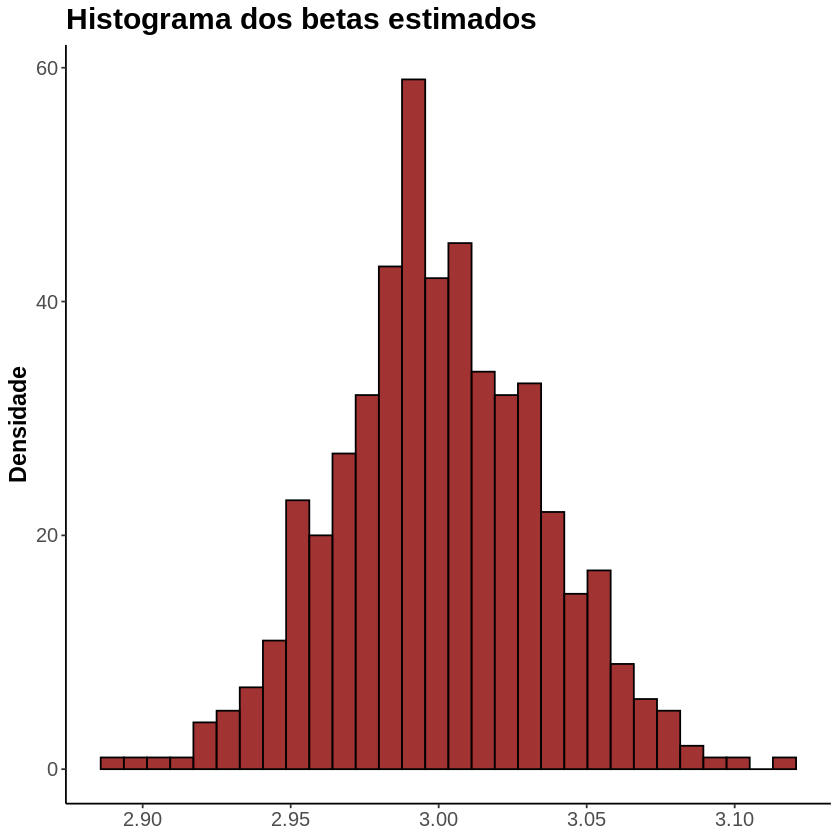

In [ ]:
# Gráfico dos betas
ggplot() +
  geom_histogram( aes(x = betas), bins = 30, color = "black", fill = "darkred", alpha = 0.8) +
  labs(title = "Histograma dos betas estimados", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

E se aumentarmos o tamanho da amostra para 2000 elementos em cada uma das 500 amostras?

In [ ]:
# Para replicarmos as variáveis pseudo aleatórias
set.seed(13)

# Definindo os parâmetros

amostras <- 500 # número de amostras

n <- 2000        # tamanho de cada amostra

b0 <- 2

b1 <- 3

# Criando as amostras

X <- replicate( amostras, rnorm( n, mean = 10, sd = 2 ) )

e <- replicate( amostras, rnorm( n, mean = 0, sd = 1 ) )

Y <- b0 + b1 * X + e

In [ ]:
# Fazendo as regressões

regressoes <- lapply( 1:amostras,
                      function(i) lm( Y[ , i ] ~ X[ , i ] ) )

betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

beta1 = mean( betas )

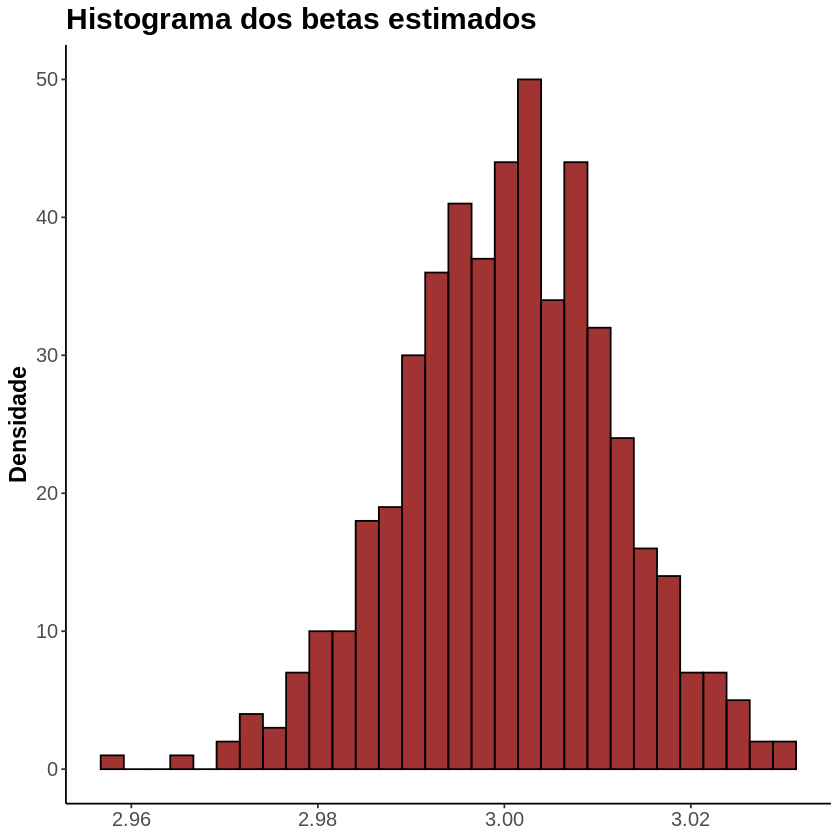

In [ ]:
# Gráfico dos betas
ggplot() +
  geom_histogram( aes(x = betas), bins = 30, color = "black", fill = "darkred", alpha = 0.8) +
  labs(title = "Histograma dos betas estimados", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

Note que a variabilidade diminuiu!

Vamos verificar a consistência do estimador:

In [ ]:
tamanhos = c( seq( from = 5, to = 90, by = 5 ),  seq( from = 100, to = 10000, by = 500 ) )

amostras = length( tamanhos ) # número de amostras

beta_mean = rep( NA, amostras )

for ( n in 1:amostras ) {

  set.seed( 13 + n )

  b0 <- 2

  b1 <- 3

  # Criando as amostras

  X <- replicate( amostras, rnorm( tamanhos[ n ], mean = 10, sd = 2 ) )

  e <- replicate( amostras, rnorm( tamanhos[ n ], mean = 0, sd = 1 ) )

  Y <- b0 + b1 * X + e

  regressoes <- lapply( 1:amostras,
                        function(i) lm( Y[ , i ] ~ X[ , i ] ) )

  betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

  beta_mean[ n ] = mean( betas ) - b1


}

NULL

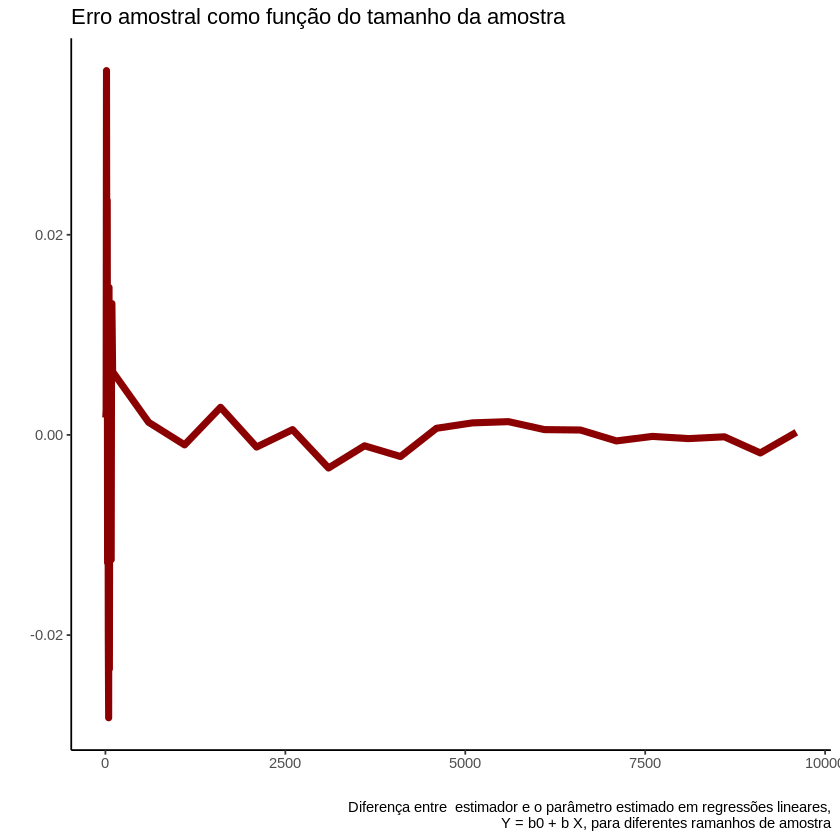

In [ ]:
data = data.frame( beta_mean, tamanhos  )

ggplot(data) +
  geom_line( aes(x = tamanhos, y = beta_mean), colour = "darkred", size = 2) +
  theme_classic() +
  labs(   title = "Erro amostral como função do tamanho da amostra",
              x = "",
              y = "",
        caption = "Diferença entre  estimador e o parâmetro estimado em regressões lineares,
                         Y = b0 + b X, para diferentes ramanhos de amostra" )

                           labs(, x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 18),
    strip.text = element_text(size = 14, face = "bold") )

### Regressão linear múltipla

Faça a dispersão entre as variáveis 'sales' e 'salary':

Estime a seguinte regressão: \\
\
$salario_i = \beta_0 + \beta_1 ROE_i + \beta_2 vendas_i + ɛ_i$


### Teorema Frisch-Waugh-Lovell

In [ ]:
# 1) Faça a regressão de 'salario' em 'ROE'.

reg = lm( salary ~ roe, data = ceosal1 )

#2) Calcule os resíduos da regressão do item (1).

e1 = reg$residuals

In [ ]:
# 3) Faça a regressão de 'vendas' em 'ROE'.

reg = lm( sales ~ roe, data = ceosal1 )

#4) Calcule os resíduos da regressão do item (3).

e2 = reg$residuals

In [ ]:
#5) Faça a regressão dos resíduos do item (1) nos resíduos do item (3) para extrair os efeitos parciais de 'vendas' em 'salario'

dat = data.frame( e1, e2 )

reg = lm( e1 ~ e2, data = dat )

summary( reg )


Call:
lm(formula = e1 ~ e2, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-1501.8  -492.6  -232.0   123.3 13575.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -2.482e-14  9.376e+01   0.000   1.0000  
e2           1.634e-02  8.852e-03   1.846   0.0663 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1355 on 207 degrees of freedom
Multiple R-squared:  0.0162,	Adjusted R-squared:  0.01144 
F-statistic: 3.408 on 1 and 207 DF,  p-value: 0.06631


Note que o coeficiente de e2 é o mesmo coeficiente de 'sales' na regressão anterior.